/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  newcm.set_over(newcm(1.0))
/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  newcm.set_under(bgcolor)
/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not 

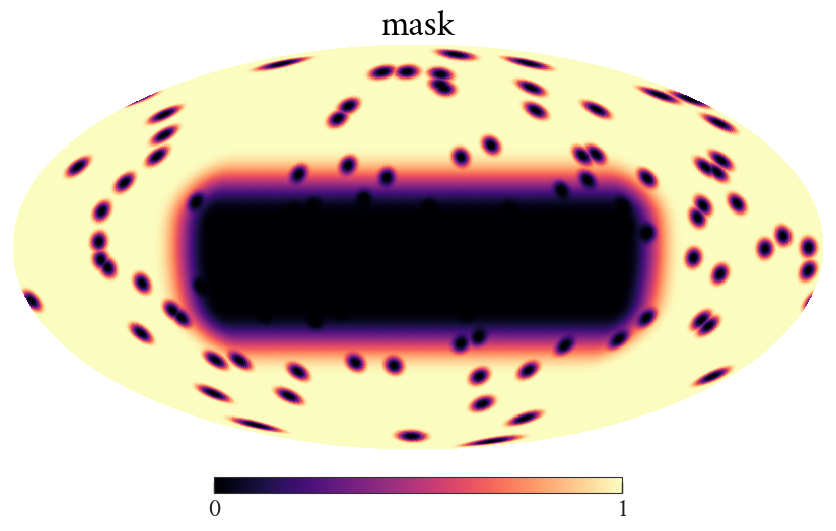

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
from scipy import linalg  # need this for cholesky decomposition and inverse

# map parameters
nside = 256
npix = hp.nside2npix(nside)
mask = np.ones(npix)

# generate a fake mask
th, ph = hp.pix2ang(nside, np.arange(npix))
ph[np.where(ph > np.pi)[0]] -= 2 * np.pi
mask[np.where((th < 1.93) & (th > np.pi/2 * 0.9) &
             (ph > -np.pi / 2) & (ph < np.pi / 2))[0]] = 0.0
mask = nmt.mask_apodization(mask, 30.0, apotype='C1')

source_mask = np.ones(npix)
source_indices = np.random.randint(0,npix-1, size=100)
source_mask[source_indices] = 0.0

mask *= nmt.mask_apodization(source_mask, 6.0, apotype='C1')

hp.mollview(mask, title="mask")

In [7]:
BIN_MIN = 2

ells = np.arange(3 * nside, dtype='int32')  # Array of multipoles
b = nmt.NmtBin(nside=nside, bpws=ells, ells=ells + BIN_MIN, weights=np.ones_like(ells))

In [8]:
larr = np.arange(3*nside)
clarr = ((larr+1.)/80.)**(-1.1)+1.
clarr[1:2] = 0.0  # make sure no mono/dipole
example_map = hp.synfast(clarr, nside, verbose=False)

f0 = nmt.NmtField(mask, [example_map])
# b = nmt.NmtBin.from_nside_linear(nside, 1)
w00 = nmt.NmtWorkspace()
w00.compute_coupling_matrix(f0, f0, b)

cl_coupled = nmt.compute_coupled_cell(f0, f0)
cl_decoupled = w00.decouple_cell(cl_coupled)

In [9]:
mcm = w00.get_coupling_matrix()
bin_no = mcm.shape[0]
lb = b.get_effective_ells()
unbinned_ells = np.arange(bin_no)

bespoke_coupled = hp.alm2cl(hp.map2alm(mask * example_map))
bespoke_decoupled = linalg.lu_solve(linalg.lu_factor(mcm[BIN_MIN:, BIN_MIN:]), b=cl_coupled[0][BIN_MIN:], trans=0)
# bespoke_decoupled = linalg.inv(mcm) @ cl_coupled[0]  # you can try to just use the matrix inverse too

# Decoupled

Text(0, 0.5, '$\\ell C_{\\ell}$')

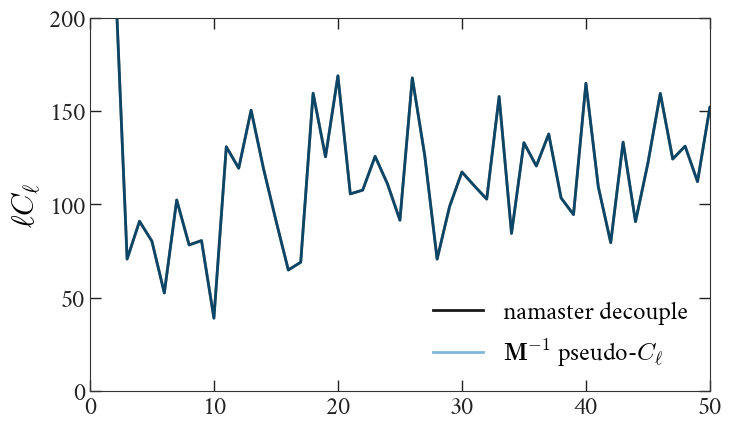

In [10]:
plt.plot(lb, cl_decoupled[0] * lb,  "-", label="namaster decouple")
plt.plot(lb, bespoke_decoupled  * lb, "-", alpha=0.5, label=r"$\mathbf{M}^{-1}$ pseudo-$C_{\ell}$")
plt.legend()
plt.xlim(0,50)
plt.ylim(0,200)
plt.ylabel(r"$\ell C_{\ell}$")

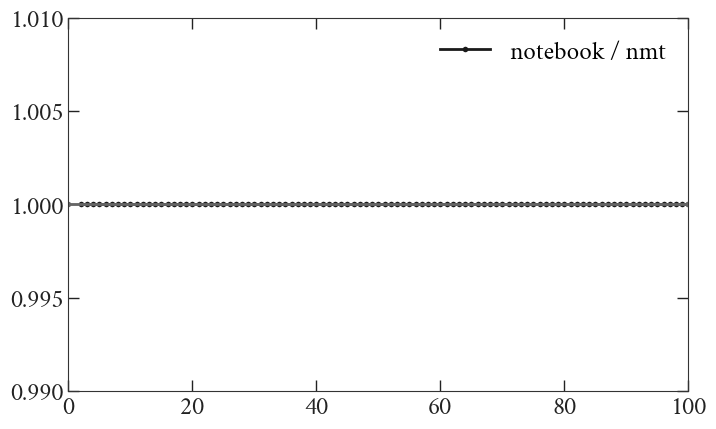

In [11]:

plt.plot(lb, bespoke_decoupled / cl_decoupled[0], label="notebook / nmt")
plt.axhline(1.0)
plt.ylim(0.99, 1.01)
plt.xlim(0, 100)
plt.legend()